# How does the number of pedestrians correlate with the weather?


In [63]:
import sys
sys.path.append('../src/')

## Weather:

Fetch data from weather station:

https://staging.dashboard.heidenheim.de/api/historical/?labelIdentifier=10517&valueKey=state

In [64]:
# Contains as key the sensor name and as value the complete data
from SmartCityHelper.Data import getAllSensors

sensorData = getAllSensors()

print(sensorData.keys())

dict_keys(['Brenzstr', 'FuZo_Eugen-Jaekle-Platz', 'FuZo_Olgastr', 'Arkaden', 'Knoepfle_Nord', 'Knoepfle_Ost'])


In [65]:
import json

with open("weather-data.json") as jsonFile:
    jsonContent = json.load(jsonFile)
    weatherData = jsonContent['data'][0]

print(weatherData.keys())
print("Number of weather data points: " + str(len(weatherData['singleDataPoints'])))
print("Example points: ", weatherData['singleDataPoints'][5])

dict_keys(['id', 'singleDataPoints', 'name', 'labelIdentifier', 'labelName', 'latitude', 'longitude', 'groupIdentifier', 'misc'])
Number of weather data points: 42358
Example points:  {'datetime': '2024-03-20T10:20:00+00:00', 'value': 'dry', 'valueKey': 'state'}


## Visualize Sensors

In [66]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

from SmartCityHelper.Filter import filterDateRange
from SmartCityHelper.Reducer import sumReducer, avgReducer, sumReducerWithReset
import datetime


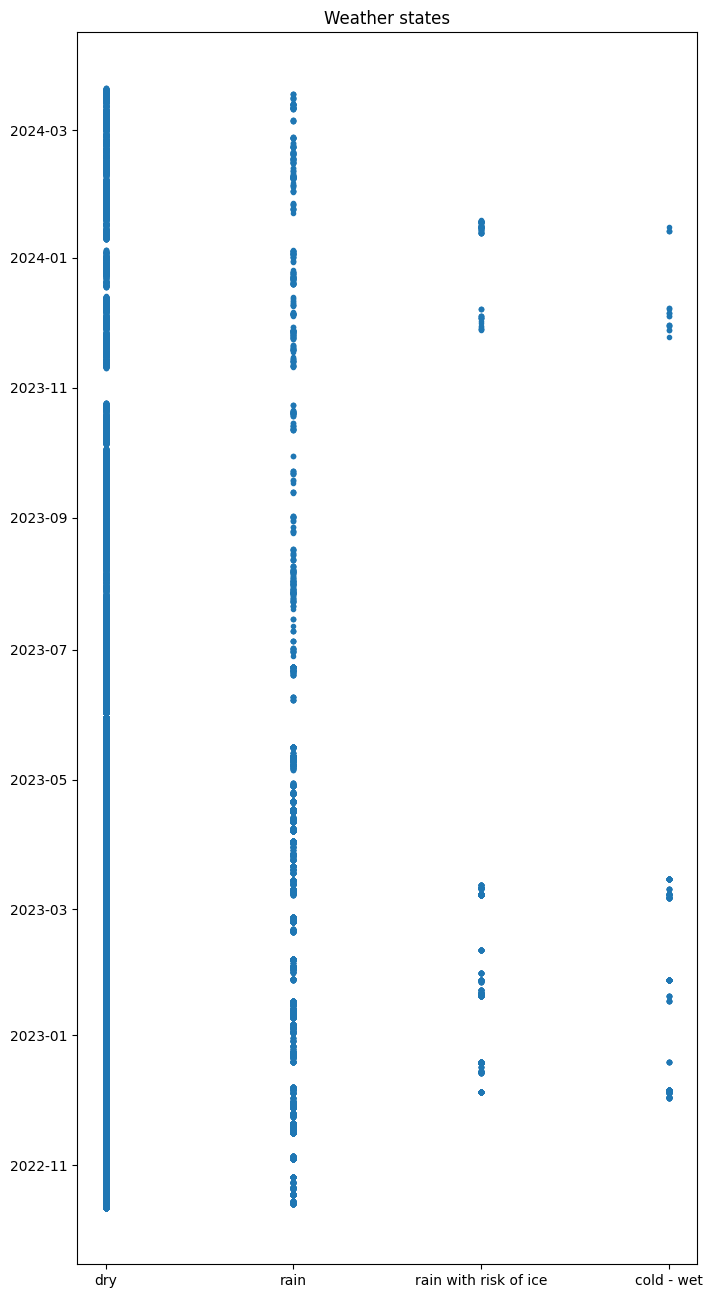

In [67]:
plt.subplots(figsize=(8, 16))

weatherDataPoints = weatherData['singleDataPoints']

yWeather = [datetime.datetime.strptime(point['datetime'][:16], '%Y-%m-%dT%H:%M') for point in weatherDataPoints]
xWeather = [point['value'] for point in weatherDataPoints]

plt.plot(xWeather, yWeather,'.')
plt.title("Weather states")
plt.savefig('weather-states.png', bbox_inches="tight")
plt.show()


We have to bundle up the data. First we sum the four labels up into "dry" and "not dry". Then we sum up the data for any day into the following json form:

```json
{
    "2024-01-01": {
        "date": "2024-01-01",
        "dry": 26,
        "not_dry": 22,
    }
}
```

In [68]:
weatherDataMap = {}


for point in weatherDataPoints:
    date = datetime.datetime.strptime(point['datetime'][:10], '%Y-%m-%d')
    dateAsString = date.strftime('%Y-%m-%d')    

    if dateAsString not in weatherDataMap:
        weatherDataMap[dateAsString] = {
            'date': date,
            'dry': 0,
            'not_dry': 0,
        }
    

    if point['value'] == 'dry':
        weatherDataMap[dateAsString]['dry'] += 1
    else:
        weatherDataMap[dateAsString]['not_dry'] += 1

print("Example point", weatherDataMap[list(weatherDataMap.keys())[0]])

Example point {'date': datetime.datetime(2024, 3, 20, 0, 0), 'dry': 15, 'not_dry': 0}


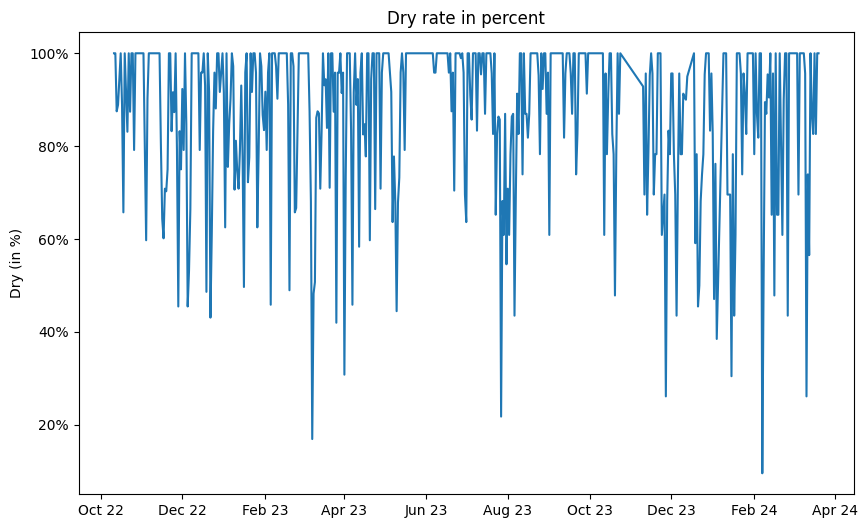

Avg dry rate:  0.8775057462162211


In [69]:
fix, ax1 = plt.subplots(figsize=(10, 6))

xWeather = [point['date'] for point in weatherDataMap.values()]
yWeather = [(point['dry'] / (point['dry'] + point['not_dry'])) for point in weatherDataMap.values()]

plt.plot(xWeather, yWeather)
ax1.set_ylabel('Dry (in %)')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1))

half_year_locator = mdates.MonthLocator(interval=2)
ax1.xaxis.set_major_locator(half_year_locator) # Locator for major axis only.
year_month_formatter = mdates.DateFormatter("%b %y") # four digits for year, two for month
ax1.xaxis.set_major_formatter(year_month_formatter) # formatter for major axis only

plt.title("Dry rate in percent")
plt.savefig('weather-dry-rate.png', bbox_inches="tight")
plt.show()

print("Avg dry rate: ", sum(yWeather) / len(yWeather))

## Filter saturdays

In [70]:
import datetime

start_date = datetime.date(2022, 10, 1)
end_date = datetime.date.today()

saturdays = []

current_date = start_date
while current_date <= end_date:
    if current_date.weekday() == 5:  # Saturday is represented by 5 in the weekday() function
        saturdays.append(current_date)
    current_date += datetime.timedelta(days=1)

saturdaysAsStrings = [date.strftime('%Y-%m-%d') for date in saturdays]

print("Example Saturdays:", saturdaysAsStrings[::30])


Example Saturdays: ['2022-10-01', '2023-04-29', '2023-11-25']


In [71]:
weatherVisitorCorrelation = {}

for saturdayAsString in saturdaysAsStrings:
    
    if saturdayAsString not in weatherDataMap:
        print("Saturday has no weather data: " + saturdayAsString)
        continue
    
    weatherVisitorCorrelation[saturdayAsString] = weatherDataMap[saturdayAsString]
    weatherVisitorCorrelation[saturdayAsString]['visitors'] = {}

for sensorName, data in sensorData.items():
    dataPoints = dict(sorted(data['singleDataPoints'].items())).values()
    
    for dataPoint in dataPoints:
        dateAsString = dataPoint['datetime'][:10]   

        if dateAsString in weatherVisitorCorrelation:
            if sensorName not in weatherVisitorCorrelation[dateAsString]['visitors']:
                weatherVisitorCorrelation[dateAsString]['visitors'][sensorName] = 0
            
            weatherVisitorCorrelation[dateAsString]['visitors'][sensorName] += int(dataPoint['person.in'])

weatherVisitorCorrelation = {date: data for date, data in weatherVisitorCorrelation.items() if data['visitors']}

print("Example correlation: ", weatherVisitorCorrelation)


Saturday has no weather data: 2022-10-01
Saturday has no weather data: 2022-10-08
Saturday has no weather data: 2023-10-28
Saturday has no weather data: 2023-11-04
Saturday has no weather data: 2023-12-16
Saturday has no weather data: 2024-01-06
Saturday has no weather data: 2024-03-23
Example correlation:  {'2022-11-12': {'date': datetime.datetime(2022, 11, 12, 0, 0), 'dry': 144, 'not_dry': 0, 'visitors': {'Brenzstr': 373, 'FuZo_Eugen-Jaekle-Platz': 6251, 'FuZo_Olgastr': 7408, 'Arkaden': 6477, 'Knoepfle_Nord': 5108, 'Knoepfle_Ost': 1012}}, '2022-11-19': {'date': datetime.datetime(2022, 11, 19, 0, 0), 'dry': 104, 'not_dry': 44, 'visitors': {'Brenzstr': 282, 'FuZo_Eugen-Jaekle-Platz': 5396, 'FuZo_Olgastr': 6645, 'Arkaden': 5685, 'Knoepfle_Nord': 3609, 'Knoepfle_Ost': 1037}}, '2022-11-26': {'date': datetime.datetime(2022, 11, 26, 0, 0), 'dry': 142, 'not_dry': 0, 'visitors': {'Brenzstr': 241, 'FuZo_Eugen-Jaekle-Platz': 5828, 'FuZo_Olgastr': 7648, 'Arkaden': 6388, 'Knoepfle_Nord': 3853, 'K

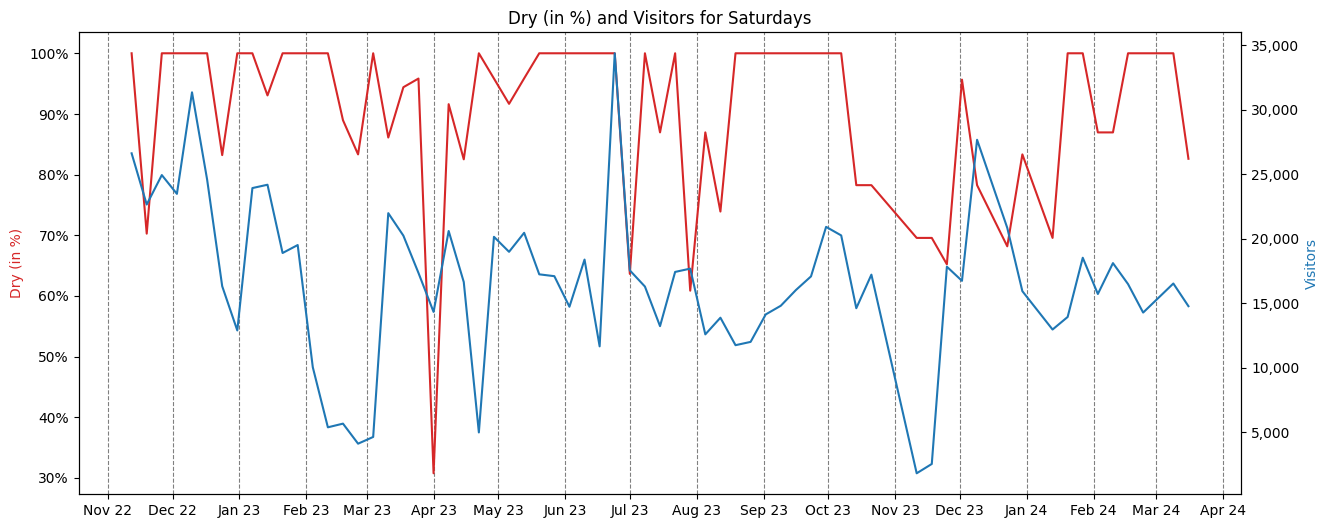

Avg dry rate:  0.9042674855864852
Dates above 25.000 visitors:  ['2022-11-12', '2022-12-10', '2023-06-24', '2023-12-09']


In [72]:
import numpy as np

fig, ax1 = plt.subplots(figsize=(15, 6))

xWeather = [point['date'] for point in weatherVisitorCorrelation.values()]
yWeather = [(point['dry'] / (point['dry'] + point['not_dry'])) for point in weatherVisitorCorrelation.values()]
yVisitors = [sum(point['visitors'].values()) for point in weatherVisitorCorrelation.values()]

color = 'tab:red'
ax1.plot(xWeather, yWeather, color=color)
ax1.set_ylabel('Dry (in %)', color=color)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1))

# Grid for x axis
ax1.set_axisbelow(True)
ax1.xaxis.grid(color='gray', linestyle='dashed')
half_year_locator = mdates.MonthLocator(interval=1)
ax1.xaxis.set_major_locator(half_year_locator) # Locator for major axis only.
year_month_formatter = mdates.DateFormatter("%b %y") # four digits for year, two for month
ax1.xaxis.set_major_formatter(year_month_formatter) # formatter for major axis only

color = 'tab:blue'
ax2 = ax1.twinx()
ax2.plot(xWeather, yVisitors, color=color)
ax2.set_ylabel('Visitors', color=color)
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.title("Dry (in %) and Visitors for Saturdays")
plt.savefig('weather-dry-rate-correlation.png', bbox_inches="tight")
plt.show()

print("Avg dry rate: ", sum(yWeather) / len(yWeather))
print("Dates above 25.000 visitors: ", [date for date, data in weatherVisitorCorrelation.items() if sum(data['visitors'].values()) > 25000])

In [73]:
import numpy as np
# Cross Corerelation
corr_coef = np.corrcoef(yWeather, yVisitors)
print("Correlation coefficient: ", corr_coef)

x = np.random.randn(100)
y = np.random.randn(100)

corr_coef = np.corrcoef(x, y)
print("Correlation coefficient:", corr_coef)

Correlation coefficient:  [[1.         0.15069405]
 [0.15069405 1.        ]]
Correlation coefficient: [[ 1.        -0.0965314]
 [-0.0965314  1.       ]]


Pearsons correlation: 0.1507
<bound method RegressorMixin.score of LinearRegression()>


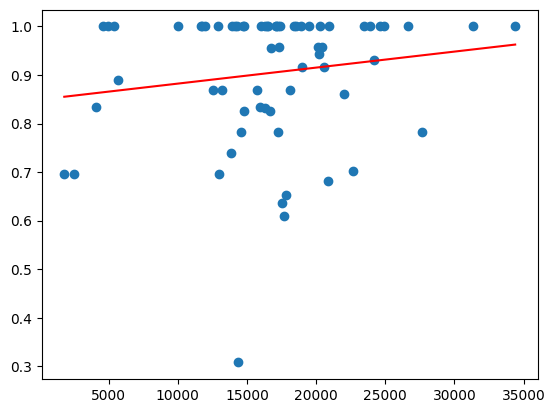

In [74]:
#https://www.scribbr.com/statistics/pearson-correlation-coefficient/
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

corr,_ = pearsonr(yVisitors, yWeather)
print('Pearsons correlation: %.4f' % corr)

yVisitors_Reshaped = np.array(yVisitors).reshape(-1, 1)

reg = LinearRegression().fit(yVisitors_Reshaped, yWeather)
print(reg.score)

X_test = np.arange(min(yVisitors), max(yVisitors)).reshape(-1, 1)
y_pred = reg.predict(X_test)

plt.plot(X_test, y_pred, color='red')

plt.scatter(yVisitors, yWeather)
plt.show()



Pearsons correlation: 0.1507


Score:  <bound method RegressorMixin.score of LinearRegression()>


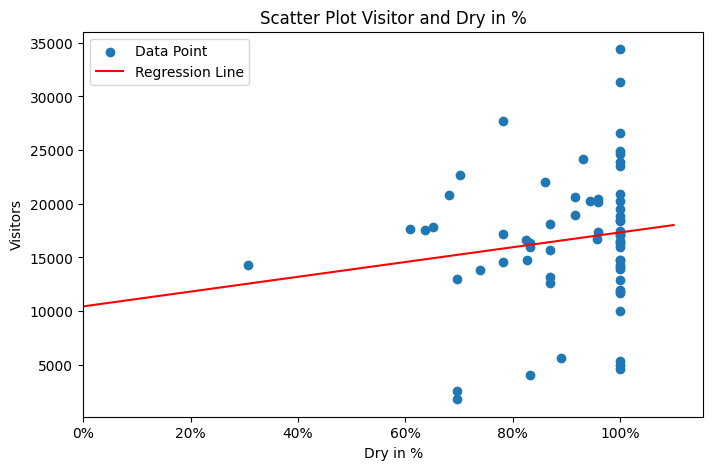

Prediction for persons on a real rainy (dry: 0 %) day: 10444
Prediction for persons on a real suny (dry: 100%) day: 17329


In [75]:
#https://www.scribbr.com/statistics/pearson-correlation-coefficient/
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

fig, ax1 = plt.subplots(figsize=(8, 5))


weatherVisitorCorrelation_Filtered = {}

# FILTER => Remove all days where the dry rate is 100%
#for date, data in weatherVisitorCorrelation.items():
#    dryRate = data['dry'] / (data['dry'] + data['not_dry'])
#    if dryRate < 1:
#        weatherVisitorCorrelation_Filtered[date] = data
#
#yWeather = [(point['dry'] / (point['dry'] + point['not_dry'])) for point in weatherVisitorCorrelation_Filtered.values()]
#yVisitors = [sum(point['visitors'].values()) for point in weatherVisitorCorrelation_Filtered.values()]



corr,_ = pearsonr(yWeather, yVisitors)
print('Pearsons correlation: %.4f' % corr)

yWeather_Reshaped = np.array(yWeather).reshape(-1, 1)

reg = LinearRegression().fit(yWeather_Reshaped, yVisitors)
print("Score: ", (reg.score))

X_test = np.arange(0, 1.15, 0.1).reshape(-1, 1)
y_pred = reg.predict(X_test)

plt.scatter(yWeather, yVisitors, label="Data Point")
plt.plot(X_test, y_pred, color='red', label="Regression Line")
plt.title("Scatter Plot Visitor and Dry in %")
plt.xlim(0)

ax1.set_ylabel('Visitors')
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax1.set_xlabel('Dry in %')
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1))
import matplotlib.pyplot as plt

plt.legend(loc='upper left')
plt.savefig('scatter-plot-weather.png')
plt.show()

print("Prediction for persons on a real rainy (dry: 0 %) day: {0}".format( int(reg.predict([[0]])[0])))
print("Prediction for persons on a real suny (dry: 100%) day: {0}".format( int(reg.predict([[1]])[0])))

# Get absoulte numbers:

In [77]:
print("MARKDOWN TABLE:")
print()
print("| Sensor | 10.02. | 17.02. | Difference |")
print("| --- | --- | --- | --- |")

for sensorName, data in sensorData.items():
    dataPoints = dict(sorted(data['singleDataPoints'].items())).values()
    dataPointsDemonstration = [d for d in dataPoints if filterDateRange(d, "2024-02-10 10:00:00", "2024-02-10 14:00:00")]
    dataPointsDemonstration = sumReducer(dataPointsDemonstration, 'person.in')

    dataPointsDemonstrationSaturday = [d for d in dataPoints if filterDateRange(d, "2024-02-17 10:00:00", "2024-02-17 14:00:00")]
    dataPointsDemonstrationSaturday = sumReducer(dataPointsDemonstrationSaturday, 'person.in')

    print("| {0} | {1} | {2} | {3} |".format(sensorName, dataPointsDemonstration[-1]['person.in'], dataPointsDemonstrationSaturday[-1]['person.in'], int(dataPointsDemonstration[-1]['person.in']) - int(dataPointsDemonstrationSaturday[-1]['person.in'])))


MARKDOWN TABLE:

| Sensor | 10.02. | 17.02. | Difference |
| --- | --- | --- | --- |
| Brenzstr | 742 | 87 | 655 |
| FuZo_Eugen-Jaekle-Platz | 2485 | 1936 | 549 |
| FuZo_Olgastr | 1464 | 1444 | 20 |
| Arkaden | 1865 | 1937 | -72 |
| Knoepfle_Nord | 988 | 473 | 515 |
| Knoepfle_Ost | 104 | 25 | 79 |


In [78]:
import folium
import random

# Create a folium map centered at a specific location
m = folium.Map(location=[48.67638280435713, 10.151585739252655], zoom_start=15, zoom_control=False)

# Add markers for each sensor
for sensorName, data in sensorData.items():
    
    #MAX_DELTA =  0.00009
    MAX_DELTA =  0.0002

    latitude = data['latitude'] + (random.uniform(0, 1) * MAX_DELTA) - (MAX_DELTA / 2)
    longitude = data['longitude'] + (random.uniform(0, 1) * MAX_DELTA) - (MAX_DELTA / 2)


    label = folium.Marker(
        location=[latitude, longitude],
        icon=folium.Icon(),
        tooltip=sensorName
    )
    label.add_to(m)

# Display the map
#m.save(outfile= "map_of_sensors.html")
m

